In [6]:
import re

from ete3 import NCBITaxa
from ebi_eva_internal_pyutils.metadata_utils import get_metadata_connection_handle
from ebi_eva_internal_pyutils.pg_utils import get_all_results_for_query
from ebi_eva_common_pyutils.ncbi_utils import get_ncbi_assembly_dicts_from_term, get_ncbi_taxonomy_dicts_from_ids, \
    get_ncbi_taxonomy_dicts_from_term

assembly_to_species_cache = {}
taxonomy_to_species_cache = {}
api_key = '01a7cfd97228eee442256df079d3581cdd09'

ete_db = NCBITaxa()

/Users/tcezard/PycharmProjects/eva-tasks/venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [7]:

def unique_on_keys(list_of_dict, keys):
    unique_values = {
        tuple((key, d.get(key)) for key in keys) for d in list_of_dict
    }
    return [dict(set_of_values) for set_of_values in unique_values]

def taxonomy_from_assembly(assembly):
    if assembly not in assembly_to_species_cache:
        assembly_info_list = get_ncbi_assembly_dicts_from_term(assembly, api_key=api_key)
        assembly_info_list = unique_on_keys(assembly_info_list, ['taxid'])
        if len(assembly_info_list) == 1:
            assembly_to_species_cache[assembly] = assembly_info_list[0]['taxid']
        else:
            print(f'No species found from assembly={assembly}')
            assembly_to_species_cache[assembly] = None
    return assembly_to_species_cache[assembly]

def species_detail_from_name_or_taxonomy(species_term=None, taxonomy_id=None):
    return_info = ['scientificname', 'taxid', 'commonname']
    if taxonomy_id and taxonomy_id not in taxonomy_to_species_cache:
        taxonomy_info_list = get_ncbi_taxonomy_dicts_from_ids([taxonomy_id], api_key=api_key)
        taxonomy_info_list = unique_on_keys(taxonomy_info_list, return_info)
        if len(taxonomy_info_list) == 1:
            taxonomy_to_species_cache[taxonomy_id] = taxonomy_info_list[0]
        else:
            print(f'No species information found from taxonomy_id={taxonomy_id}')
            taxonomy_to_species_cache[taxonomy_id] = None
    elif species_term and species_term not in taxonomy_to_species_cache:
        taxonomy_info_list = get_ncbi_taxonomy_dicts_from_term(species_term, api_key=api_key)
        taxonomy_info_list = unique_on_keys(taxonomy_info_list, return_info)
        if len(taxonomy_info_list) == 1:
            taxonomy_to_species_cache[species_term] = taxonomy_info_list[0]
        else:
            print(f'No species information found from species_term={species_term}')
            taxonomy_to_species_cache[species_term] = None
    if taxonomy_id:
        return  taxonomy_to_species_cache[taxonomy_id]
    elif species_term:
        return  taxonomy_to_species_cache[species_term]


def extract_information_from_release_filename(file_name):
    sp_file_name = file_name.split('/')
    release = sp_file_name[5]
    species_match = re.search('by_species/(.+?)/', file_name)
    accession_match = re.search('(GCA_\d{9}\.\d)', file_name)
    info_dict = None
    if species_match:
        species_match_group = species_match.group(1)
        info_dict = species_detail_from_name_or_taxonomy(species_term=species_match_group.replace('_', ' '))
        if not info_dict and species_match_group.split('_')[-1].isdigit():
            info_dict = species_detail_from_name_or_taxonomy(taxonomy_id=species_match_group.split('_')[-1])
        if not info_dict and species_match_group.split(' ')[-1].isdigit():
            info_dict = species_detail_from_name_or_taxonomy(taxonomy_id=species_match_group.split(' ')[-1])
    if not info_dict and accession_match:
        assembly_accession = accession_match.group(1)
        taxonomy_id = taxonomy_from_assembly(assembly_accession)
        info_dict = species_detail_from_name_or_taxonomy(taxonomy_id=taxonomy_id)
    if info_dict and info_dict.get('taxid'):
        # Get all the taxids of the ranks above in the taxonomy tree
        lineage = ete_db.get_lineage(int(info_dict['taxid']))
        # Get the rank of each taxonomy ids
        ranks = ete_db.get_rank(lineage)
        # Only use rank class
        required_rank = 'class'
        # Get the taxonomy of the class
        taxid_for_rank = [i for i in ranks if ranks[i] == required_rank]
        if taxid_for_rank:
            # Get the name of the class
            sci_name_of_required_rank = ete_db.get_taxid_translator(taxid_for_rank)[taxid_for_rank[0]]
            name_of_required_rank = ete_db.get_common_names(taxid_for_rank).get(taxid_for_rank[0]) or ete_db.get_taxid_translator(taxid_for_rank).get(taxid_for_rank[0]) or taxid_for_rank[0]
        else:
            name_of_required_rank = 'NA'
        info_dict[required_rank] = name_of_required_rank
        info_dict['release'] = release
        return info_dict
    else:
        return {'release': release}

In [8]:
# File containing password not committed to the repository
private_config_xml_file = 'maven_settings.xml'
query = '''select event_ts, uhost,  file_name, file_size
           from eva_web_srvc_stats.ftp_traffic
           where file_size>0  and file_name  like '%rs_releases%';'''
data = []
with get_metadata_connection_handle('production_processing', private_config_xml_file) as db_conn:
    for event_ts, uhost, file_name, file_size in get_all_results_for_query(db_conn, query):
        info_dict = extract_information_from_release_filename(file_name)
        data.append((event_ts, uhost, file_name, file_size, info_dict.get('release'), info_dict.get('commonname') or info_dict.get('scientificname'),
                     info_dict.get('scientificname'), info_dict.get('class')))

No species information found from species_term=Rat 10116
No species information found from species_term=Mouse 10090
No species information found from species_term=Zebrafish 7955
No species information found from species_term=Vervet monkey 60711
No species information found from species_term=Dog 9615
No species information found from species_term=Pig 9823
No species information found from species_term=Cow 9913
No species information found from species_term=Prevotella timonensis 386414
No species information found from species_term=Gray short tailed opossum 13616
No species information found from species_term=Intestinibacter bartlettii 261299
No species information found from species_term=Acinetobacter sp  472
No species information found from species_term=Sockeye salmon 8023
No species information found from species_term=Eggerthella lenta 84112
No species information found from species_term=Holdemanella biformis 1735
No species information found from species_term=Kidney bean 3885
No spe

/Users/tcezard/PycharmProjects/eva-tasks/venv/lib/python3.9/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 469587 was translated into 817
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))


No species information found from species_term=Honey bee 7460
No species information found from species_term=Chicken 9031
No species information found from species_term=Carrot 79200
No species information found from species_term=Megamonas hypermegale 158847
No species information found from species_term=Methanobrevibacter smithii 2173
No species information found from species_term=Salmonella enterica 28901
No species information found from species_term=Sheep 9940
No species information found from species_term=Caenorhabditis briggsae 6238
No species information found from species_term=Calcareous tube worm 216498
No species information found from species_term=Chum salmon 8018
No species information found from species_term=Lactobacillus reuteri 1598
No species information found from species_term=Nile tilapia 8128
No species information found from species_term=Sea vase 7719
No species information found from species_term=Cat 9685
No species information found from species_term=House sparrow 

/Users/tcezard/PycharmProjects/eva-tasks/venv/lib/python3.9/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 563191 was translated into 187327
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))


No species information found from species_term=Acinetobacter baumannii 470
No species information found from species_term=Acinetobacter baylyi 202950
No species information found from species_term=Absiella dolichum 31971
No species information found from species_term=Acinetobacter johnsonii 40214
No species information found from species_term=Acinetobacter nosocomialis 106654
No species information found from species_term=Ficedula hypoleuca 46689
No species information found from species_term=Acinetobacter pittii 48296
No species information found from species_term=Clostridium leptum 1535
No species information found from species_term=Coho salmon 8019
No species information found from species_term=Alistipes shahii 328814
No species information found from species_term=Acinetobacter calcoaceticus 471
No species information found from species_term=African oil palm 51953
No species information found from species_term=Clostridium asparagiforme 333367
No species information found from specie

/Users/tcezard/PycharmProjects/eva-tasks/venv/lib/python3.9/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 469586 was translated into 818
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))


No species information found from species_term=Bacteroides vulgatus 821
No species information found from species_term=Chinook salmon 74940
No species information found from species_term=Black cottonwood 3694
No species information found from species_term=Faecalitalea cylindroides 39483
No species information found from species_term=Candida albicans 5476
No species information found from species_term=Great tit 9157
No species information found from species_term=Collared flycatcher 59894
No species information found from species_term=Enterococcus faecalis 1351
No species information found from species_term=Hungatella hathewayi 154046
No species information found from species_term=Hybrid cattle 30522
No species information found from species_term=Japanese quail 93934
No species information found from species_term=Apple 3750
No species information found from species_term=Oxalobacter formigenes 847
No species information found from species_term=Mitsuokella multacida 52226
No species inform

In [9]:
import pandas as pd
from datetime import datetime
df = pd.DataFrame(data, columns =['event_ts', 'uhost', 'file_name', 'file_size', 'release', 'commonname', 'scientificname', 'class'])

In [10]:

# remove any entry that does not have a class and split per year
tmpdf = df[df['class']!='']
df_2023 = tmpdf[(tmpdf['event_ts'] > datetime(year=2023, month=1, day=1)) & (tmpdf['event_ts'] < datetime(year=2024, month=1, day=1))]
df_2022 = tmpdf[(tmpdf['event_ts'] > datetime(year=2022, month=1, day=1)) & (tmpdf['event_ts'] < datetime(year=2023, month=1, day=1))]
df_2021 = tmpdf[(tmpdf['event_ts'] > datetime(year=2021, month=1, day=1)) & (tmpdf['event_ts'] < datetime(year=2022, month=1, day=1))]
df_2020 = tmpdf[(tmpdf['event_ts'] > datetime(year=2020, month=1, day=1)) & (tmpdf['event_ts'] < datetime(year=2021, month=1, day=1))]


## Number of request for downloading data from all releases per class in 2022

Text(0.5, 0, 'Taxonomy class')

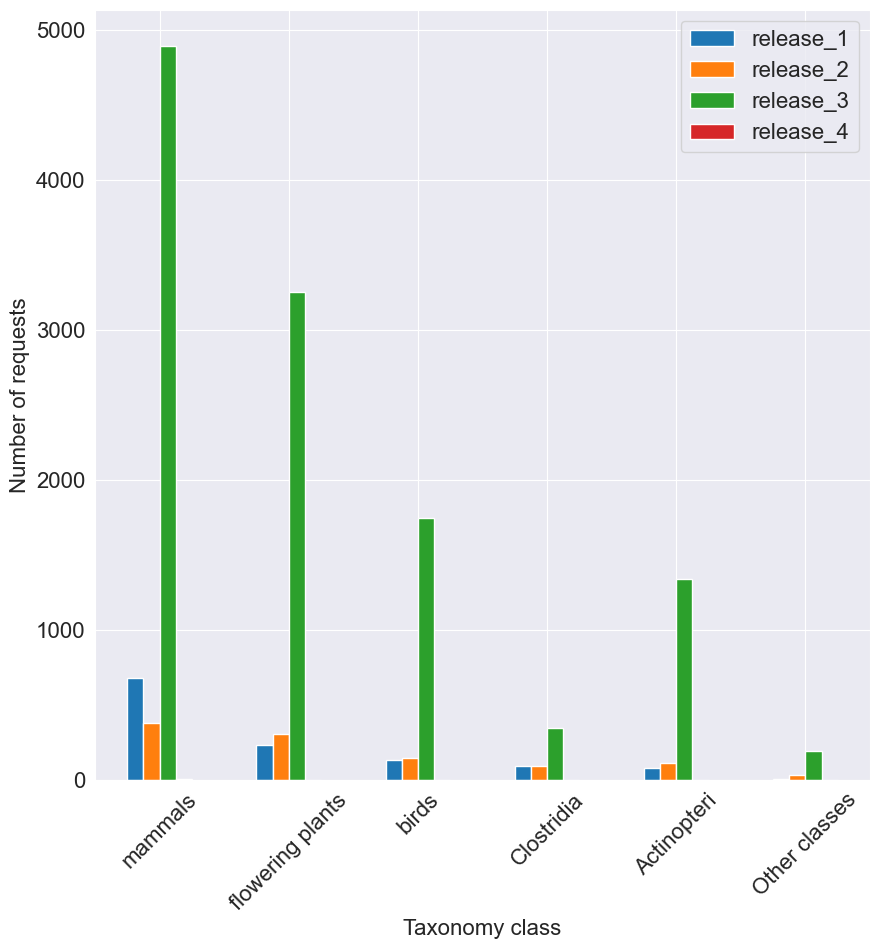

In [9]:
## Number of request for downloading data from both releases per class
grouped_df = df_2022.groupby(['class', 'release']).uhost.count().unstack()
# Remove the rows where both release have no data
grouped_df = grouped_df[grouped_df['release_1'].notnull() | grouped_df['release_2'].notnull()]
grouped_df = grouped_df.sort_values('release_1', ascending=False)
nb_categories = 5
def collapse_last_rows(dataframe, nb_rows_left, collapse_row_name='Others'):
    # Shenanigan to get the last set of rows summed up
    last_rows = dataframe.iloc[-nb_rows_left:].sum().reset_index().transpose()
    last_rows.columns = last_rows.iloc[0]
    last_rows = last_rows.rename(index={0: collapse_row_name}).drop('release')
    return pd.concat([dataframe[:nb_rows_left], last_rows])
grouped_df = collapse_last_rows(grouped_df, 5, 'Other classes')
axes = grouped_df.plot(kind='bar', y=['release_%s' % r for r in range(1,5)], rot=45, figsize=(10, 10), fontsize=16)
axes.legend(prop={"size":16})
axes.set_ylabel('Number of requests', fontdict={'fontsize':16})
axes.set_xlabel('Taxonomy class', fontdict={'fontsize':16})



## Number of unique IP that downloaded data from both releases per class in 2022

Text(0.5, 0, 'Taxonomy class')

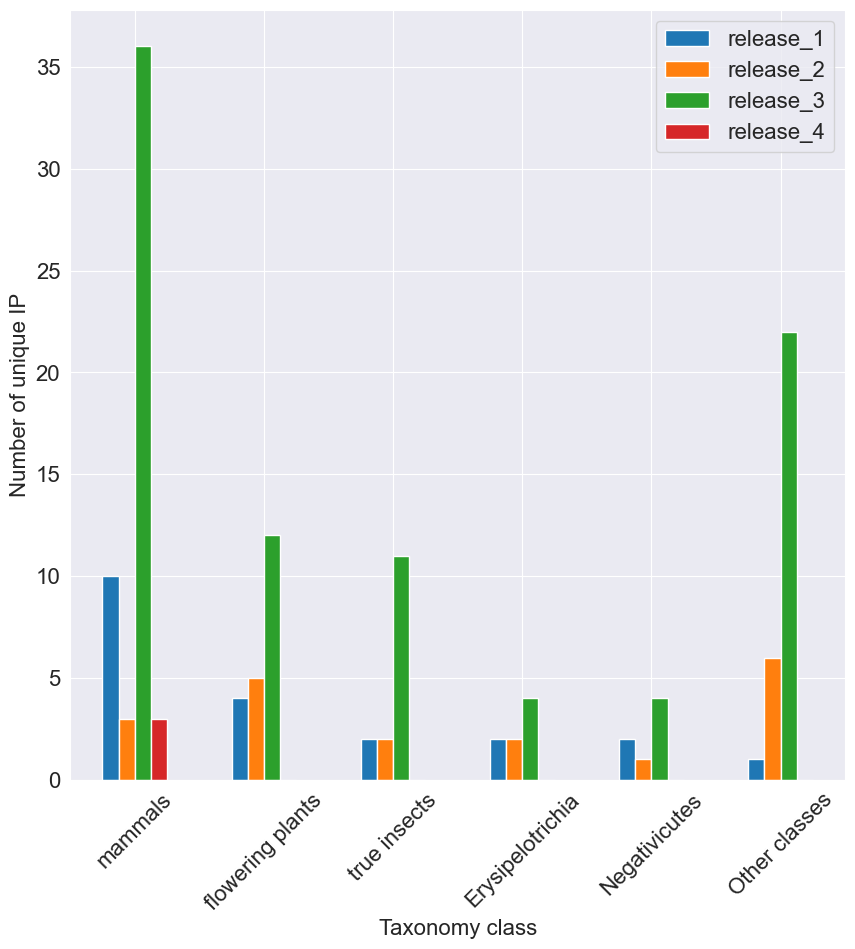

In [10]:
## Number of unique IP that downloaded data from both releases per class
grouped_df = df_2022.groupby(['class', 'release']).uhost.nunique().unstack()
# Remove the rows where both release have no data
grouped_df = grouped_df[grouped_df['release_1'].notnull() | grouped_df['release_2'].notnull()]
grouped_df = grouped_df .sort_values('release_1', ascending=False)
grouped_df = collapse_last_rows(grouped_df, 5, 'Other classes')

axes = grouped_df.plot(kind='bar', y=['release_%s' % r for r in range(1,5)], rot=45, figsize=(10, 10), fontsize=16)
axes.legend(prop={"size":16})
axes.set_ylabel('Number of unique IP', fontdict={'fontsize':16})
axes.set_xlabel('Taxonomy class', fontdict={'fontsize':16})

In [11]:
from matplotlib import pyplot as plt

def donut_plot(data_frame, group='commonname', value='file_size', nb_categories=6):
    if value == 'file_size':
        grouped_df = data_frame.groupby([group])[value].sum().reset_index()
    elif value == 'uhost':
        grouped_df = data_frame.groupby([group])[value].nunique().reset_index()
    elif value == 'nb_request':
        value = 'uhost'
        grouped_df = data_frame.groupby([group])[value].count().reset_index()
    grouped_df = grouped_df.sort_values(value, ascending=False)
    if group == 'class':
        other = 'Other classes'
    else:
        other = 'Other species'

    grouped_df_simple = pd.concat([
        grouped_df[:nb_categories],
        pd.DataFrame(
            [[other, sum(grouped_df[nb_categories:][value])]],
            columns=[group, value]
        )
    ])
    colors = ['#003f5c','#2f4b7c','#665191','#a05195','#d45087','#f95d6a','#ff7c43','#ffa600']
    axes = grouped_df_simple.plot(y=value, labels=grouped_df_simple[group], kind='pie', autopct='%1.f%%', figsize=(10, 10), legend=False, colors=colors, fontsize=16, counterclock=False, startangle=90)
    centre_circle = plt.Circle((0,0),0.70,fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)
    axes.set_ylabel('')

## Proportion of the all unique IPs downloading data per species

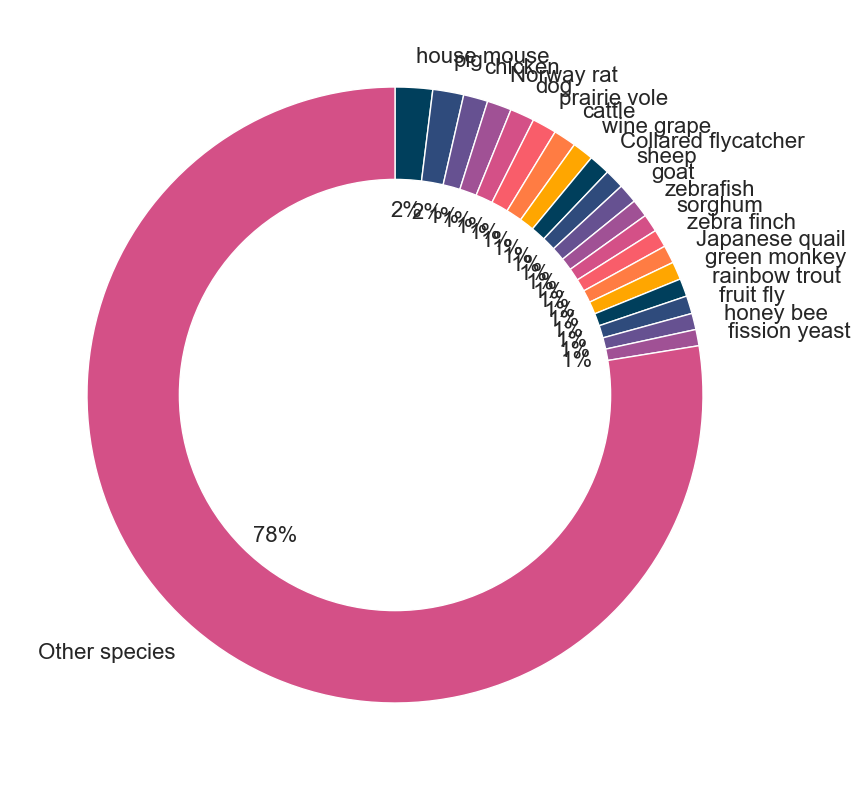

In [12]:
donut_plot(df_2022, 'commonname', value='uhost', nb_categories=20)

## Proportion of the all unique IPs downloading data per class

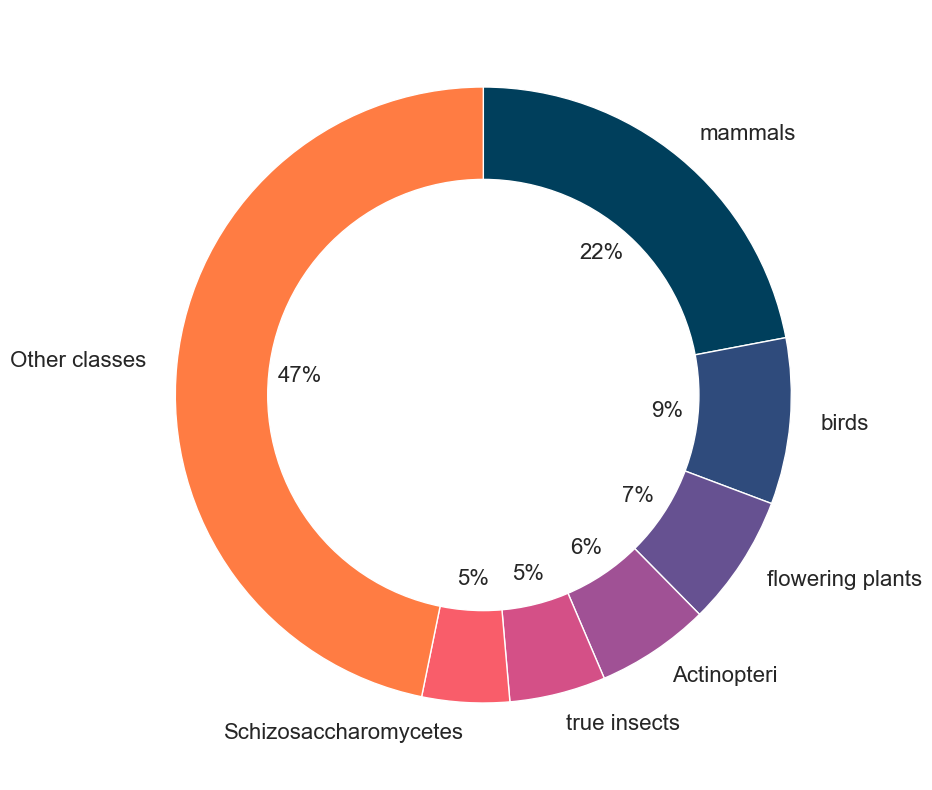

In [13]:
donut_plot(df_2022, 'class', value='uhost', nb_categories=6)

## Download of the Actual VCF file per release per quarter.

Text(0.5, 0, 'Time')

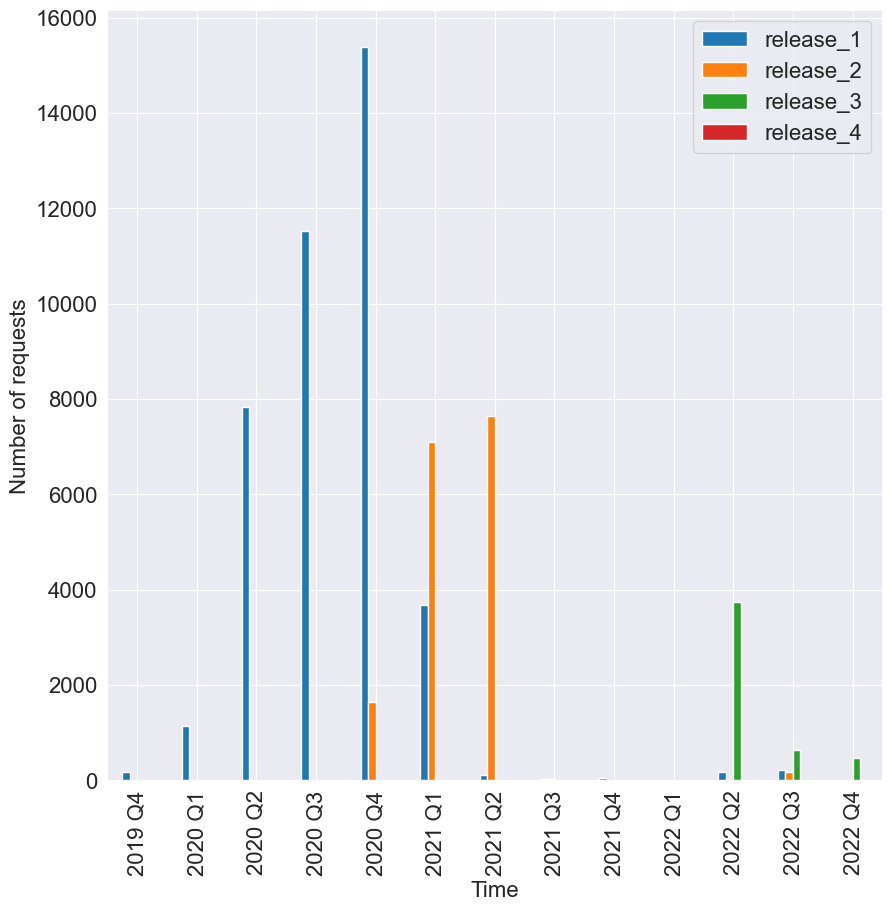

In [14]:
df2 = df[df['file_name'].str.contains('current')]
df2 = df2[(df2['event_ts'] > datetime(year=2019, month=10, day=1)) & (df2['event_ts'] < datetime(year=2023, month=1, day=1))]

df2.index = pd.to_datetime(df2['event_ts'])
grouped_df = df2[df2['file_name'].str.contains('current')].groupby([ pd.Grouper(freq="Q"), 'release']).file_size.count().unstack()
grouped_df['quarter'] = ['2019 Q4', '2020 Q1', '2020 Q2', '2020 Q3', '2020 Q4', '2021 Q1', '2021 Q2', '2021 Q3', '2021 Q4', '2022 Q1', '2022 Q2', '2022 Q3', '2022 Q4']
axes = grouped_df.plot(kind='bar', y=['release_%s' % r for r in range(1,5)], rot=90, figsize=(10, 10), fontsize=16)
axes.set_xticklabels(grouped_df.quarter)
axes.legend(prop={"size":16})
axes.set_ylabel('Number of requests', fontdict={'fontsize':16})
axes.set_xlabel('Time', fontdict={'fontsize':16})

## More detail view of the previous graph per week.

[Text(0, 0, '2019 - week 40'),
 Text(1, 0, '2019 - week 41'),
 Text(2, 0, '2019 - week 42'),
 Text(3, 0, '2019 - week 43'),
 Text(4, 0, '2019 - week 44'),
 Text(5, 0, '2019 - week 45'),
 Text(6, 0, '2019 - week 46'),
 Text(7, 0, '2019 - week 47'),
 Text(8, 0, '2019 - week 48'),
 Text(9, 0, '2019 - week 49'),
 Text(10, 0, '2019 - week 50'),
 Text(11, 0, '2019 - week 51'),
 Text(12, 0, '2019 - week 52'),
 Text(13, 0, '2020 - week 1'),
 Text(14, 0, '2020 - week 2'),
 Text(15, 0, '2020 - week 3'),
 Text(16, 0, '2020 - week 4'),
 Text(17, 0, '2020 - week 5'),
 Text(18, 0, '2020 - week 6'),
 Text(19, 0, '2020 - week 7'),
 Text(20, 0, '2020 - week 8'),
 Text(21, 0, '2020 - week 9'),
 Text(22, 0, '2020 - week 10'),
 Text(23, 0, '2020 - week 11'),
 Text(24, 0, '2020 - week 12'),
 Text(25, 0, '2020 - week 13'),
 Text(26, 0, '2020 - week 14'),
 Text(27, 0, '2020 - week 15'),
 Text(28, 0, '2020 - week 16'),
 Text(29, 0, '2020 - week 17'),
 Text(30, 0, '2020 - week 18'),
 Text(31, 0, '2020 - week 1

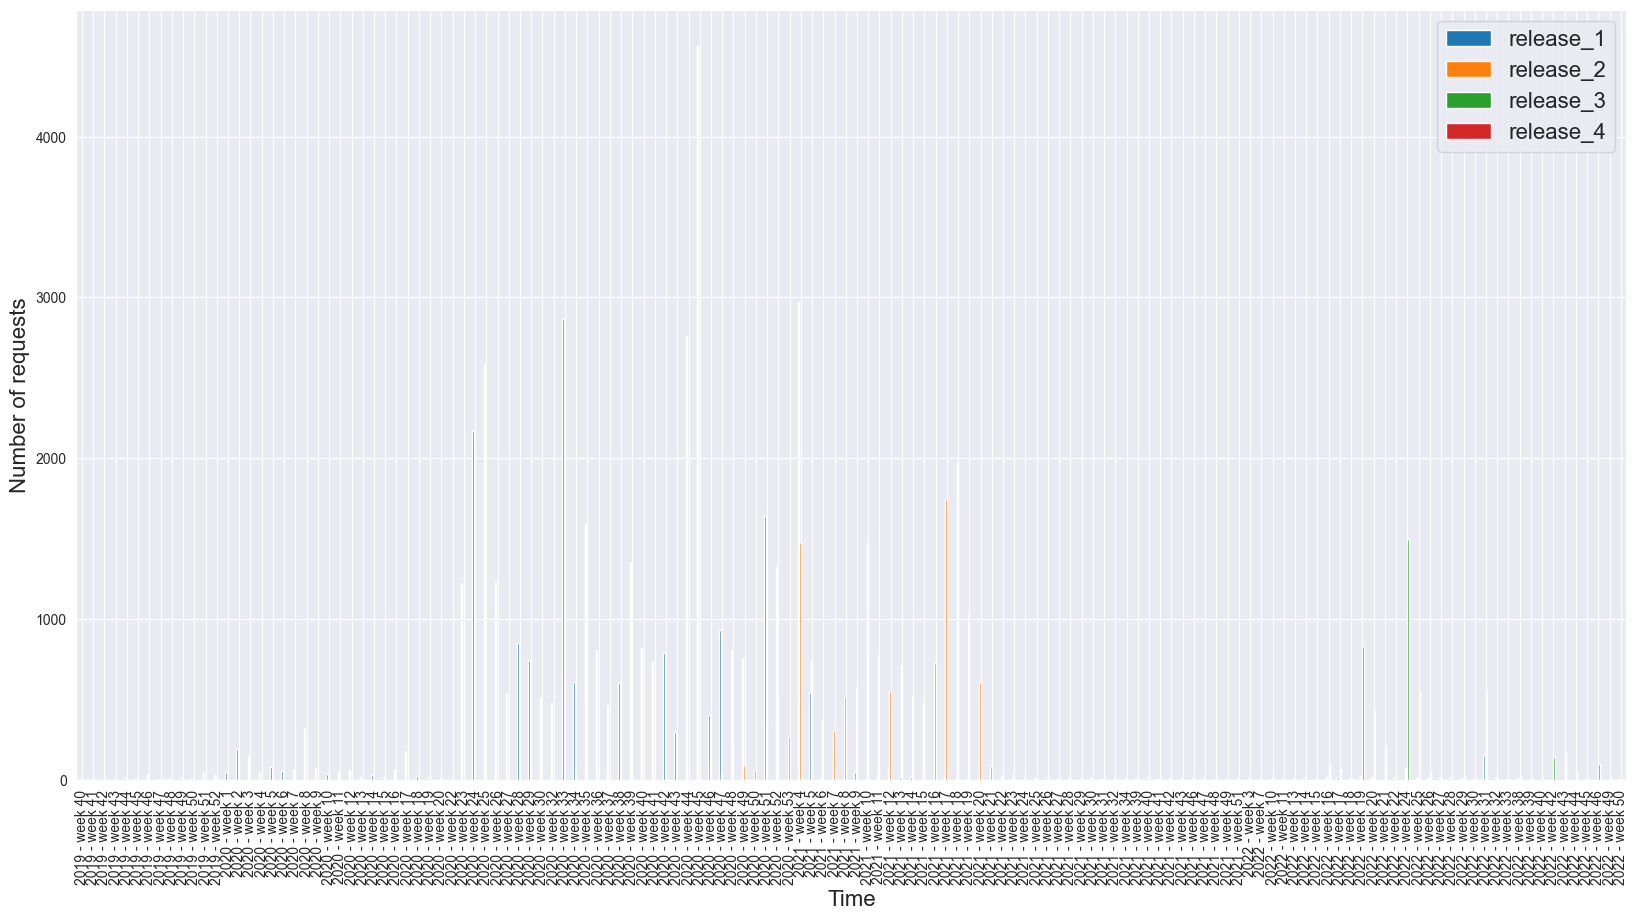

In [15]:
df2 = df[df['file_name'].str.contains('current')]
df2 = df2[(df2['event_ts'] > datetime(year=2019, month=10, day=1)) & (df2['event_ts'] < datetime(year=2023, month=1, day=1))]

df2.index = pd.to_datetime(df2['event_ts'])
grouped_df = df2[df2['file_name'].str.contains('current')].groupby([ pd.Grouper(freq="W"), 'release']).file_size.count().unstack()
axes = grouped_df.plot(kind='bar', y=['release_%s' % r for r in range(1,5)], rot=90, figsize=(20, 10), fontsize=10)
axes.legend(prop={"size":16})
axes.set_ylabel('Number of requests', fontdict={'fontsize':16})
axes.set_xlabel('Time', fontdict={'fontsize':16})
axes.set_xticklabels(grouped_df.index.map(lambda d: f'{d.isocalendar()[0]} - week {d.isocalendar()[1]}'))